In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("notebook", rc={"lines.linewidth": 3})
##################################################
plt.style.use('tableau-colorblind10')
##################################################
import numpy as np

In [2]:
#start here to run analysis
def read_common_edges(cate):
    all_df= pd.read_csv(f"{cate}_common_edges.txt",index_col=None)
    df_cl = pd.read_csv("../leave_one_out/braun_data_clinical_data.csv")
    df_os = pd.merge(all_df.T.reset_index(),df_cl,how='left', left_on="index", right_on="RNA_ID")
    df_os_merge = df_os.T
    df_os_merge[1] = df_os_merge[0] +"_" + df_os_merge[1]
    df_os_merge = df_os_merge[df_os_merge.columns[1:]].T
    df_os_merge.columns = df_os_merge.iloc[0]
    df_os_merge.drop(1,inplace=True)
    df_os_merge.columns = df_os_merge.columns.tolist()[:-13] + df_os.columns.tolist()[-13:]
    df_os_merge.dropna(axis=1,inplace=True)
    return df_os_merge

def read_common_edges(cate):
    all_df= pd.read_csv(f"{cate}_common_edges.txt",index_col=None)
    df_cl = pd.read_csv("../leave_one_out/braun_data_clinical_data.csv")
    df_os = pd.merge(all_df.T.reset_index(),df_cl,how='left', left_on="index", right_on="RNA_ID")
    df_os_merge = df_os.T
    df_os_merge[1] = df_os_merge[0] +"_" + df_os_merge[1]
    df_os_merge = df_os_merge[df_os_merge.columns[1:]].T
    df_os_merge.columns = df_os_merge.iloc[0]
    df_os_merge.drop(1,inplace=True)
    df_os_merge.columns = df_os_merge.columns.tolist()[:-13] + df_os.columns.tolist()[-13:]
    df_os_merge.dropna(axis=1,inplace=True)
    
    for i in df_os_merge.iloc[:,1:-13].columns:
        up_fence  = df_os_merge[i].quantile(0.95)
        low_fence  = df_os_merge[i].quantile(0.05)
        df_os_merge[i][df_os_merge[i]>up_fence*1.1] = up_fence
        df_os_merge[i][df_os_merge[i]<low_fence*0.9] = low_fence
    return df_os_merge

In [3]:
cate = "primaryNivo"  # ["primaryNivo","primaryEver","metaNivo","metaEver"]:

df_os_merge =read_common_edges(cate)

df_cox_os = pd.read_csv(f"./cox_result/cox_result_{cate}_os.txt",index_col=0)
df_cox_pfs = pd.read_csv(f"./cox_result/cox_result_{cate}_pfs.txt",index_col=0)

temp = df_os_merge.set_index("A_B")[df_os_merge.columns[1:-14]].T

tp1 = df_cox_pfs[df_cox_pfs["p"]<0.01].index.tolist()

temp.loc[tp1].T.mean()[temp.loc[tp1].T.mean()<0]

#edges_cox = set(df_cox_pfs[df_cox_pfs["p"]<0.05].index.tolist()).union(df_cox_os[df_cox_os["p"]<0.05].index.tolist())
edges_inter = set(df_cox_pfs[df_cox_pfs["p"]<0.05].index.tolist()).intersection(df_cox_os[df_cox_os["p"]<0.05].index.tolist())
#edges_inter = df_cox_pfs[df_cox_pfs["p"]<0.01].index.tolist()
#edges_inter = df_cox_os[df_cox_os["p"]<0.001].index.tolist()
print(len(edges_inter))


df_sns = df_os_merge.copy().sort_values(by="Benefit").iloc[:,:-13].set_index("A_B")[list(edges_inter)]

colors = df_os_merge.copy().sort_values(by="Benefit")["Benefit"].replace("ICB","yellow").replace("NCB","red").replace("CB","green").tolist()

"""
colors =[]
for i in  df_os_merge.copy().sort_values(by="Benefit")["PFS"]:
    if i >= 6:
        colors.append("green")
    elif i <=3:
        colors.append("red")
    else:
        colors.append("yellow")

"""
df_sns = df_sns.astype("float64")

#df_os_merge.copy()[["A_B","Benefit"] + list(edges_inter)+df_os_merge.columns[-13:].tolist()].to_csv(f"{cate}_cluster_matrix.csv")

#sns.heatmap(df_sns)
# T test is not performed here
sns.clustermap(df_sns,method="ward",row_colors= colors,row_cluster=True,z_score=1)


In [4]:
#df_sns.to_csv(f"consens_input_{cate}.txt")

import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_sns.to_numpy())
dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node")
plt.show()

#df_os_merge[df["Benefit"]=="CB"&df["Benefit"]=="NCB"]
#only keep cb and ncb
df_sns = df_os_merge[df_os_merge["Benefit"].isin(["CB","NCB"])].copy().sort_values(by="Benefit").iloc[:,:-13].set_index("A_B")[list(edges_inter)]
colors = df_os_merge[df_os_merge["Benefit"].isin(["CB","NCB"])].copy().sort_values(by="Benefit")["Benefit"].replace("ICB","yellow").replace("NCB","red").replace("CB","green").tolist()
df_sns = df_sns.astype("float64")
#sns.heatmap(df_sns)
# T test is not performed here
sns.clustermap(df_sns,method="ward",row_colors= colors,row_cluster=True,z_score=1)


In [5]:
edges_inter = set(df_cox_pfs[df_cox_pfs["p"]<0.01].index.tolist()).intersection(df_cox_os[df_cox_os["p"]<0.01].index.tolist())
#edges_cox = set(df_cox_pfs[df_cox_pfs["p"]<0.1].index.tolist()).union(df_cox_os[df_cox_os["p"]<0.1].index.tolist())
print(len(edges_inter))
print(len(df_cox_os[df_cox_os["p"]<0.01].index.tolist()))
print(len(df_cox_pfs[df_cox_pfs["p"]<0.01].index.tolist()))

df_cox_result = df_os_merge[["A_B"]+list(edges_inter)+["Benefit"]]

51
214
224


In [6]:
import scipy
import matplotlib.pyplot as plt
import scienceplots

plt.rc('font', family='DejaVu Sans')

df_sns = df_os_merge.copy().sort_values(by="Benefit").iloc[:,:-13].set_index("A_B")[list(edges_inter)]
df_sns = df_sns.astype("float64")

colors = df_os_merge.set_index("A_B")["Benefit"].copy().replace("ICB","#6d6e71")\
                    .replace("NCB","#E7131A").replace("CB","#005baa")

In [8]:
df_sns.to_csv(f"ML_input_{cate}.txt")

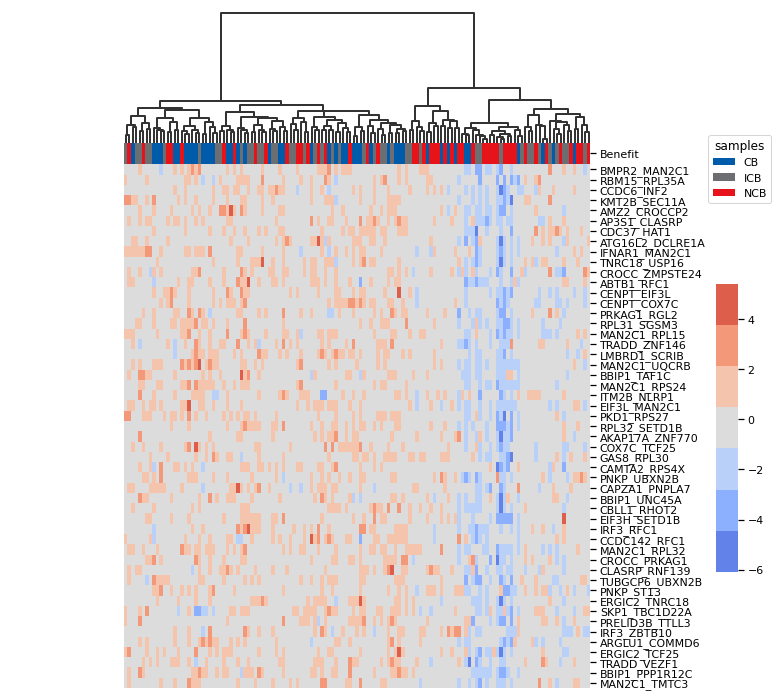

In [21]:
#df_os_merge.copy()[["A_B","Benefit"] + list(significant_edges)+df_os_merge.columns[-13:].tolist()].to_csv(f"{cate}_sign_cluster_matrix.csv")
#sns.heatmap(df_sns)
g1 = sns.clustermap(df_sns.T,method="ward",metric="cosine",cmap=sns.color_palette("coolwarm", 7)\
                    ,col_colors= colors,col_cluster=True,row_cluster=False,xticklabels=False,z_score=0,yticklabels=True)#,cmap="Blues")
plt.setp(g1.ax_heatmap.get_xticklabels(), rotation=90) 
ax = g1.ax_heatmap
ax.set_xlabel("")
g1.ax_cbar.set_position((1, .2, .03, .4))

dic = {"ICB":"#6d6e71","NCB":"#E7131A","CB":"#005baa"}

for label in ["CB","ICB","NCB"]:
    g1.ax_col_dendrogram.bar(0, 0, color=dic[label], label=label, linewidth=0)
l1 = g1.ax_col_dendrogram.legend(title='samples', loc="best", ncol=1, bbox_to_anchor=(1.4, 0.10))

for a in g1.ax_col_dendrogram.collections:
    a.set_linewidth(2)

plt.savefig(f"f4.{cate}_edge.tif",dpi=600,bbox_inches='tight')
plt.savefig(f"f4.{cate}_edge.svg",dpi=600,bbox_inches='tight')
plt.show()
plt.close()

#df_sns.to_csv(f"consens_input_{cate}.txt")

edges_inter = set(df_cox_pfs[df_cox_pfs["p"]<0.05].index.tolist()).intersection(df_cox_os[df_cox_os["p"]<0.05].index.tolist())
#edges_cox = set(df_cox_pfs[df_cox_pfs["p"]<0.1].index.tolist()).union(df_cox_os[df_cox_os["p"]<0.1].index.tolist())

df_cox_result = df_os_merge[["A_B"]+list(edges_inter)+["Benefit"]]
df_cox_cb = df_cox_result[df_cox_result["Benefit"]=="CB"]
print(df_cox_cb.columns)
df_cox_ncb = df_cox_result[df_cox_result["Benefit"]=="NCB"]
#print(df_cox_cb[list(edges_inter)].mean())
#print(df_cox_ncb[list(edges_inter)].mean())
import scipy

significant_edges = []

for i in edges_inter:
    t_Pvalue = scipy.stats.ttest_ind(df_cox_cb[i].tolist(),df_cox_ncb[i].tolist(),\
                            equal_var=[scipy.stats.levene(df_cox_cb[i],df_cox_ncb[i])[1] > 0.05])[1]
    if t_Pvalue < 0.05:
        significant_edges.append(i)
    #print(t_Pvalue)
print(len(significant_edges))
#print(significant_edges)
import matplotlib.pyplot as plt
df_sns = df_os_merge.copy().sort_values(by="Benefit").iloc[:,:-13].set_index("A_B")[significant_edges]
colors = df_os_merge.copy().sort_values(by="Benefit")["Benefit"].replace("ICB","yellow").replace("NCB","red").replace("CB","green").tolist()
df_sns = df_sns.astype("float64")

df_os_merge.copy()[["A_B","Benefit"] + list(significant_edges)+df_os_merge.columns[-13:].tolist()].to_csv(f"{cate}_sign_cluster_matrix.csv")
#sns.heatmap(df_sns)
g1 = sns.clustermap(df_sns,method="ward",metric="cosine",cmap="RdBu_r",row_colors= colors,row_cluster=True,yticklabels=False,z_score=1)#,cmap="Blues")
plt.setp(g1.ax_heatmap.get_xticklabels(), rotation=90) 
plt.show()

#df_sns.to_csv(f"consens_input_{cate}.txt")

# add weight of sampleps in dataframe
wei = pd.read_csv("../leave_one_out/primaryNivo.weight.txt",sep="\t",header=None)
wei_merge = pd.merge(df_sns.reset_index(),wei,how="left",left_on="A_B",right_on=0)

g1 = sns.clustermap(wei_merge[df_sns.columns.tolist()+[1]],method="ward",\
                    cmap="RdBu_r",row_colors= colors,row_cluster=True,yticklabels=False,z_score=1)#,cmap="Blues")
plt.setp(g1.ax_heatmap.get_xticklabels(), rotation=90) 
plt.show()

In [8]:
df_sns.reset_index()

A_B  BMPR2_MAN2C1  RBM15_RPL35A  \
0                 P66425-06G-Run1_S30_L002     -0.621330     -0.591212   
1                                 EA647826     -0.567511     -0.574032   
2     G109543_RCCBMS-00007-T_v1_RNA_OnPrem     -0.572226     -0.540276   
3    G109543_RCCBMS-00076-T2_v1_RNA_OnPrem     -0.580447     -0.579164   
4     G109543_RCCBMS-00114-T_v1_RNA_OnPrem     -0.569977     -0.583740   
..                                     ...           ...           ...   
128               P66287-09H-Run1_S14_L001     -0.650092     -0.704217   
129               P66291-07B-Run1_S17_L002     -0.577110     -0.598056   
130                P66291-07E-Run1_S3_L001     -0.594255     -0.568824   
131   G138701_RCCBMS-00092-T_v1_RNA_OnPrem     -0.590385     -0.576384   
132   G138701_RCCBMS-00165-T_v1_RNA_OnPrem     -0.516261     -0.584133   

     CCDC6_INF2  KMT2B_SEC11A  AMZ2_CROCCP2  AP3S1_CLASRP  CDC37_HAT1  \
0     -0.576902     -0.592898     -0.617021     -0.633534   -0.625694   
1     -0.507591     -0.447598     -0.535445     -0.558813   -0.515098   
2     -0.504657     -0.567841     -0.564112     -0.533683   -0.546055   
3     -0.478972     -0.566252     -0.558978     -0.582619   -0.522513   
4     -0.586951     -0.556502     -0.653486     -0.560454   -0.558599   
..          ...           ...           ...           ...         ...   
128   -0.581296     -0.674596     -0.619639     -0.643970   -0.550552   
129   -0.535093     -0.583522     -0.560136     -0.561089   -0.545081   
130   -0.526556     -0.577511     -0.587775     -0.547679   -0.564743   
131   -0.531886     -0.575963     -0.560832     -0.556680   -0.563227   
132   -0.522952     -0.571622     -0.585411     -0.540756   -0.499602   

     ATG16L2_DCLRE1A  IFNAR1_MAN2C1  ...  PNKP_ST13  ERGIC2_TNRC18  \
0          -0.681027      -0.546815  ...  -0.625812      -0.605600   
1          -0.596494      -0.551095  ...  -0.511321      -0.613747   
2          -0.571149      -0.537941  ...  -0.570229      -0.605793   
3          -0.543706      -0.531828  ...  -0.566652      -0.571849   
4          -0.587462      -0.569270  ...  -0.582395      -0.615935   
..               ...            ...  ...        ...            ...   
128        -0.632407      -0.643079  ...  -0.597146      -0.680997   
129        -0.574894      -0.548185  ...  -0.574224      -0.624234   
130        -0.564743      -0.560207  ...  -0.566179      -0.615025   
131        -0.579123      -0.613767  ...  -0.638234      -0.603803   
132        -0.578625      -0.550738  ...  -0.561387      -0.577453   

     SKP1_TBC1D22A  PRELID3B_TTLL3  IRF3_ZBTB10  ARGLU1_COMMD6  ERGIC2_TCF25  \
0        -0.539077       -0.543515    -0.556945      -0.643599     -0.547041   
1        -0.536838       -0.586661    -0.618297      -0.556047     -0.582196   
2        -0.524315       -0.583968    -0.587252      -0.502496     -0.573365   
3        -0.477702       -0.538083    -0.609869      -0.564326     -0.570775   
4        -0.542028       -0.583162    -0.480984      -0.592820     -0.560627   
..             ...             ...          ...            ...           ...   
128      -0.579305       -0.643961    -0.597968      -0.563326     -0.646716   
129      -0.555047       -0.612381    -0.585234      -0.567012     -0.562030   
130      -0.542660       -0.595077    -0.599017      -0.559274     -0.556456   
131      -0.557738       -0.614751    -0.607554      -0.563435     -0.577293   
132      -0.534686       -0.570641    -0.615722      -0.535752     -0.561081   

     TRADD_VEZF1  BBIP1_PPP1R12C  MAN2C1_TMTC3  
0      -0.622095       -0.616791     -0.651681  
1      -0.512125       -0.575802     -0.638134  
2      -0.500901       -0.575703     -0.625800  
3      -0.456071       -0.611378     -0.648996  
4      -0.545253       -0.558851     -0.670392  
..           ...             ...           ...  
128    -0.559795       -0.645891     -0.704631  
129    -0.530122       -0.574683     -0.639348  
130    -0.554827       -0.5578

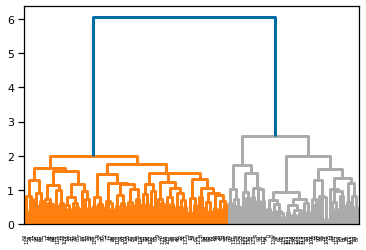

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.stats import zscore
from scipy.spatial.distance import pdist

linkage_data = linkage(pdist(zscore(df_sns), 'cosine'), method='ward', metric='euclidean')
dn = dendrogram(linkage_data)
plt.show() 

In [10]:
def swapPositions(lis):
    newlis = []
    for i in lis:
        if i == 1:
            newlis.append(2)
        if i == 2:
            newlis.append(1)
    return newlis

In [11]:
from scipy.cluster.hierarchy import fcluster

fl = fcluster(linkage_data,2,criterion='maxclust')
## only for meta Ever 
#fl[fl == 1] = 2
#fl[fl == 3] = 1


print(fl)
df_os = df_os_merge.copy().sort_values(by="Benefit").copy()
df_os["cres"] = fl
#df_os["cres"] =swapPositions(fl)
#df_os["cres"].to_csv(f"../clustering_comparison/{cate}.edges.label.txt")

[2 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 2 1 1 2 2 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 2 2 1 2 1 1 1 2 2 1 1 1 1 1 2 1 2 2 1 1 2 1 1 1 1 2 2
 2 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 2 2 2 1 1 2 1 2 2 2 1 2 1 2 2 1 2 1 1
 2 2 1 1 2 1 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 1]


133
1.586370868687052e-05
c1_CB: 34 c1_ICB: 29 c1_NCB: 18
c2_CB: 10 c2_ICB: 14 c2_NCB: 28


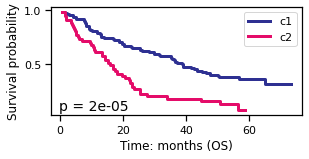

In [12]:
#OS survival analysis
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

y = df_os[["OS_CNSR","OS"]].values

y = np.array([ (i[0],i[1]) for i in y],dtype="bool,f")

#df_os_fl[df_os_fl[tar]>df_os[tar].quantile(0.65)] = "higher"
group_indicator = df_os["cres"]
print(len(group_indicator))
chi2, pvalue= compare_survival(y,group_indicator)
print(pvalue)

######################
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 2))
#####################
df_os["OS_CNSR"] = df_os["OS_CNSR"]==1

dc = {2:"#e40c69",1:"#2e3092",3:'#6d6e71'}
for i in set(fl):
    speci_df = df_os[df_os["cres"]==i]
    print(f"c{i}_CB:",speci_df["Benefit"].tolist().count("CB"),
         f"c{i}_ICB:",speci_df["Benefit"].tolist().count("ICB"),
         f"c{i}_NCB:",speci_df["Benefit"].tolist().count("NCB"),)
    time, survival_prob, conf_int = kaplan_meier_estimator(
        speci_df["OS_CNSR"], \
        speci_df["OS"], conf_type="log-log"
)
    plt.step(time, survival_prob, where="post", label=f"c{i}",color=dc[i])
    #plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="ipost")
    
ax.text(0.03, 0.15, "p = "+str(round(pvalue,5)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top')
plt.ylabel("Survival probability")
plt.xlabel("Time: months (OS)")
plt.legend(loc="best")  
plt.savefig(f"f4.{cate}_edge_os.tif",dpi=600,bbox_inches='tight')
plt.savefig(f"f4.{cate}_edge_os.svg",dpi=600,bbox_inches='tight')
plt.show()
plt.close()

133
True
c1_CB: 34 c1_ICB: 29 c1_NCB: 18
c2_CB: 10 c2_ICB: 14 c2_NCB: 28


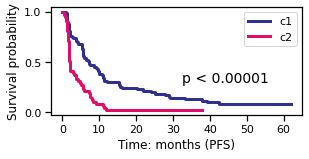

In [13]:
y = df_os[["PFS_CNSR","PFS"]].values
y = np.array([ (i[0],i[1]) for i in y],dtype="bool,f")

#df_os_fl[df_os_fl[tar]>df_os[tar].quantile(0.65)] = "higher"
group_indicator = df_os["cres"]
print(len(group_indicator))
chi2, pvalue= compare_survival(y,group_indicator)
print(pvalue < .00001)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 2))
df_os["PFS_CNSR"] = df_os["PFS_CNSR"]==1

for i in set(fl):
    speci_df = df_os[df_os["cres"]==i]
    print(f"c{i}_CB:",speci_df["Benefit"].tolist().count("CB"),
         f"c{i}_ICB:",speci_df["Benefit"].tolist().count("ICB"),
         f"c{i}_NCB:",speci_df["Benefit"].tolist().count("NCB"),)
    time, survival_prob, conf_int = kaplan_meier_estimator(
        speci_df["PFS_CNSR"], \
        speci_df["PFS"], conf_type="log-log"
)
    plt.step(time, survival_prob, where="post", label=f"c{i}",color=dc[i])
    #plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

#ax.text(0.52, 0.5, "p = "+str(round(pvalue,5)), transform=ax.transAxes, fontsize=14, verticalalignment='top')
ax.text(0.52, 0.4, "p < 0.00001", transform=ax.transAxes, fontsize=14, verticalalignment='top')



plt.ylabel("Survival probability")
plt.xlabel("Time: months (PFS)")
plt.legend(loc="best")  
plt.savefig(f"f4.{cate}_edge_pfs.tif",dpi=600,bbox_inches='tight')
plt.savefig(f"f4.{cate}_edge_pfs.svg",dpi=600,bbox_inches='tight')
plt.show()
plt.close()

df_sns.to_csv(f"{cate}_significant_edge.txt")

for i in significant_edges:
    i1 = i.split("_")
    for j in i1:
        print(j)

# PCA is needed

Explained variation per principal component: [0.37214251 0.05565349]


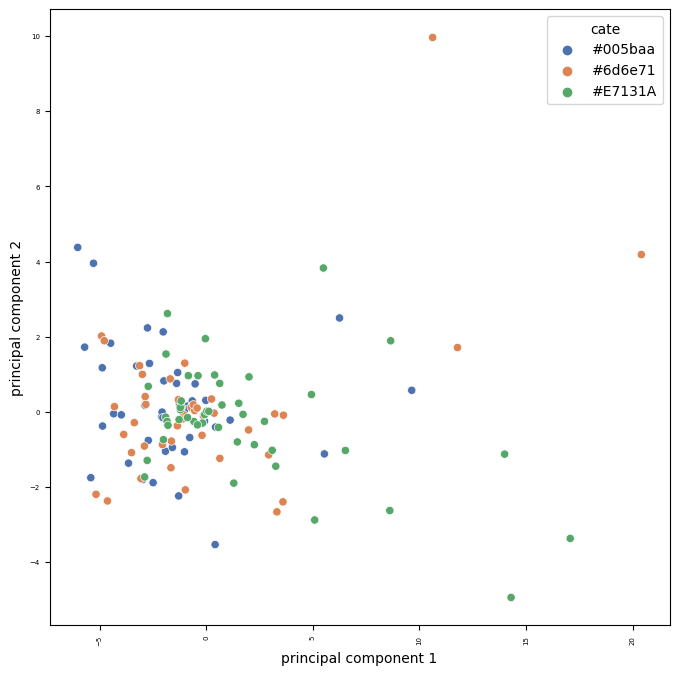

In [36]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 

X_std = StandardScaler().fit_transform(df_sns) 
X_pca = PCA(n_components=2)
principalComponents_X = X_pca.fit_transform(X_std) 
print('Explained variation per principal component: {}'.format(X_pca.explained_variance_ratio_))
df_pca = pd.DataFrame(data = principalComponents_X, columns = ['principal component 1', 'principal component 2']) 
df_pca["cate"] = colors

plt.figure(figsize=(8, 8)) 
sns.scatterplot(data=df_pca, hue="cate", x="principal component 1", y="principal component 2",legend="full", palette="deep") 
plt.xticks(fontsize=5, rotation=90)
plt.yticks(fontsize=5)
plt.show()

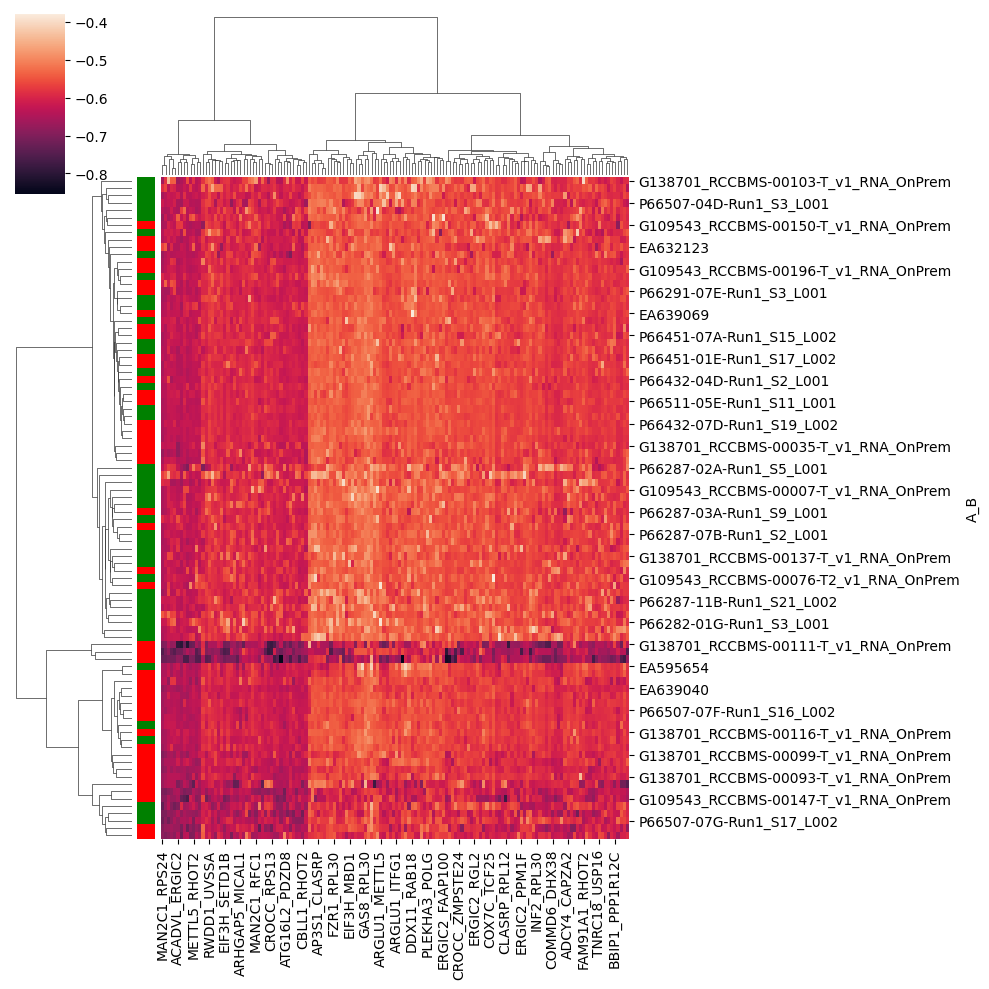

In [19]:
#df_os_merge[df["Benefit"]=="CB"&df["Benefit"]=="NCB"]
#only keep cb and ncb
df_sns = df_os_merge[df_os_merge["Benefit"].isin(["CB","NCB"])].copy().sort_values(by="Benefit").iloc[:,:-13].set_index("A_B")[list(significant_edges)]
colors = df_os_merge[df_os_merge["Benefit"].isin(["CB","NCB"])].copy().sort_values(by="Benefit")["Benefit"].replace("ICB","yellow").replace("NCB","red").replace("CB","green").tolist()
df_sns = df_sns.astype("float64")
#sns.heatmap(df_sns)
# T test is not performed here
sns.clustermap(df_sns,method="ward",row_colors= colors,row_cluster=True)#,z_score=1)


[[ 0.          7.85676021  7.85676021  0.        ]
 [ 0.          9.31734648  9.31734648  7.85676021]
 [ 0.          9.7993298   9.7993298   0.        ]
 [ 9.31734648 11.06893871 11.06893871  9.7993298 ]
 [ 0.          8.88825544  8.88825544  0.        ]
 [ 0.          9.15966694  9.15966694  0.        ]
 [ 8.88825544 11.03922916 11.03922916  9.15966694]
 [ 0.          9.17621442  9.17621442  0.        ]
 [ 0.          8.88867505  8.88867505  0.        ]
 [ 0.          9.40691857  9.40691857  0.        ]
 [ 8.88867505  9.88163554  9.88163554  9.40691857]
 [ 9.17621442 12.12977662 12.12977662  9.88163554]
 [11.03922916 12.70723925 12.70723925 12.12977662]
 [11.06893871 13.02211088 13.02211088 12.70723925]
 [ 0.          6.87682348  6.87682348  0.        ]
 [ 0.          9.96209433  9.96209433  0.        ]
 [ 6.87682348 13.1861104  13.1861104   9.96209433]
 [ 0.          8.40677605  8.40677605  0.        ]
 [ 0.          8.54523096  8.54523096  0.        ]
 [ 0.          9.79857196  9.79

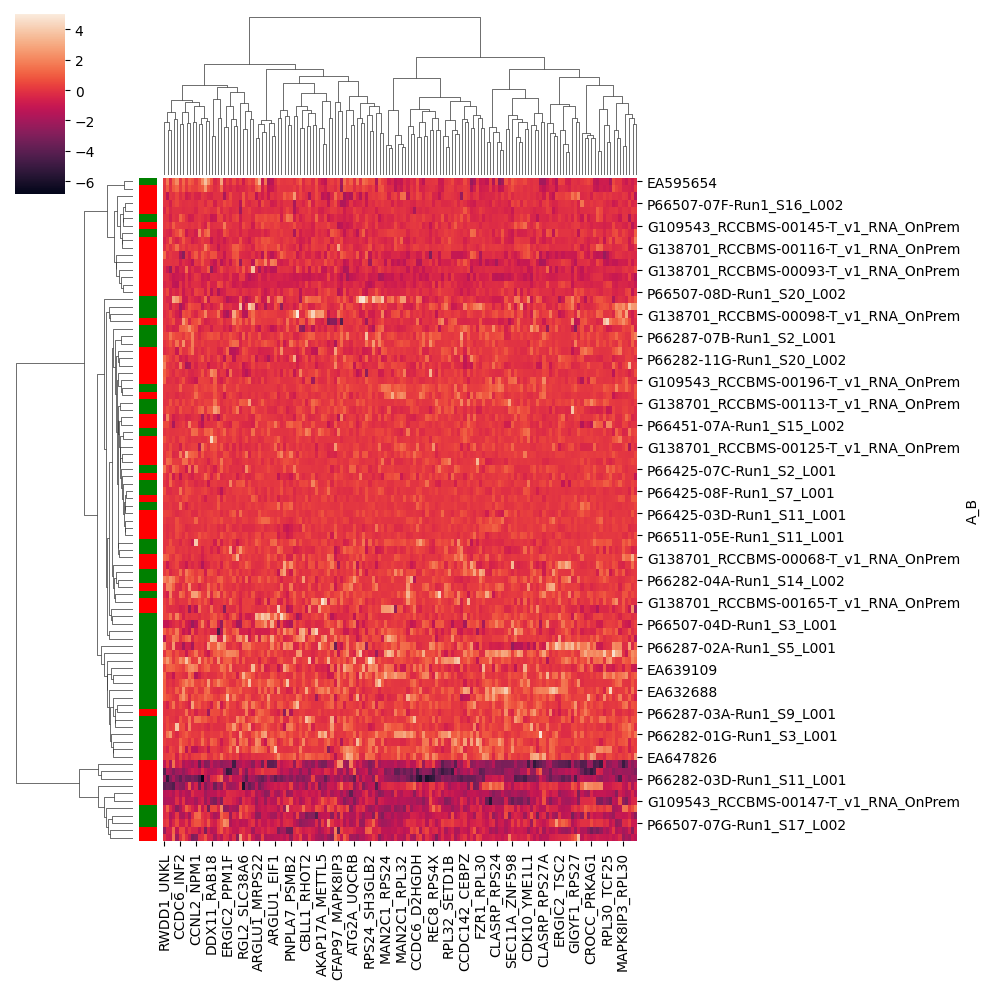

In [20]:
h = sns.clustermap(df_sns,method="ward",row_colors= colors,row_cluster=True,z_score=1)
dgram = h.dendrogram_col.dendrogram
D = np.array(dgram['dcoord'])
I = np.array(dgram['icoord'])
print(D)
# then the root node will be the last entry, and the length of the L/R branches will be
yy = D[-1] 
lenL = yy[1]-yy[0]
lenR = yy[2]-yy[3]